<a href="https://colab.research.google.com/github/parteeksingh24/ECS171_FinalProject/blob/main/ForestFiresProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [36]:
# Load the forest fires dataset
df_forest_fires = pd.read_csv('forest+fires/forestfires.csv')
print(df_forest_fires)

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]


In [37]:
# Initial data exploration
df_forest_fires.info() # Check data structure
df_forest_fires.describe() # Check basic statistics about dataset
df_forest_fires.isnull().sum() # Make sure no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

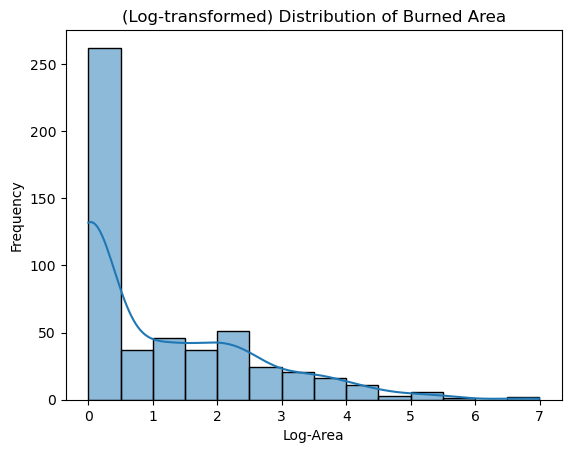

In [38]:
# Visualize data distribution

# Create binary target variable -- has a fire occured or not?
df_forest_fires['fire_occurred'] = df_forest_fires['area'].apply(lambda x: 1 if x > 0 else 0)
# Column based on the Area > 0 or = 0

# Display 'area' (target variable) using a histogram
# Apply  log transformation to 'area' to reduce skewness, improve visualization
df_forest_fires['log_area'] = np.log1p(df_forest_fires['area'])
sns.histplot(df_forest_fires['log_area'], kde=True)
plt.title('(Log-transformed) Distribution of Burned Area')
plt.xlabel('Log-Area')
plt.ylabel('Frequency')
plt.show()

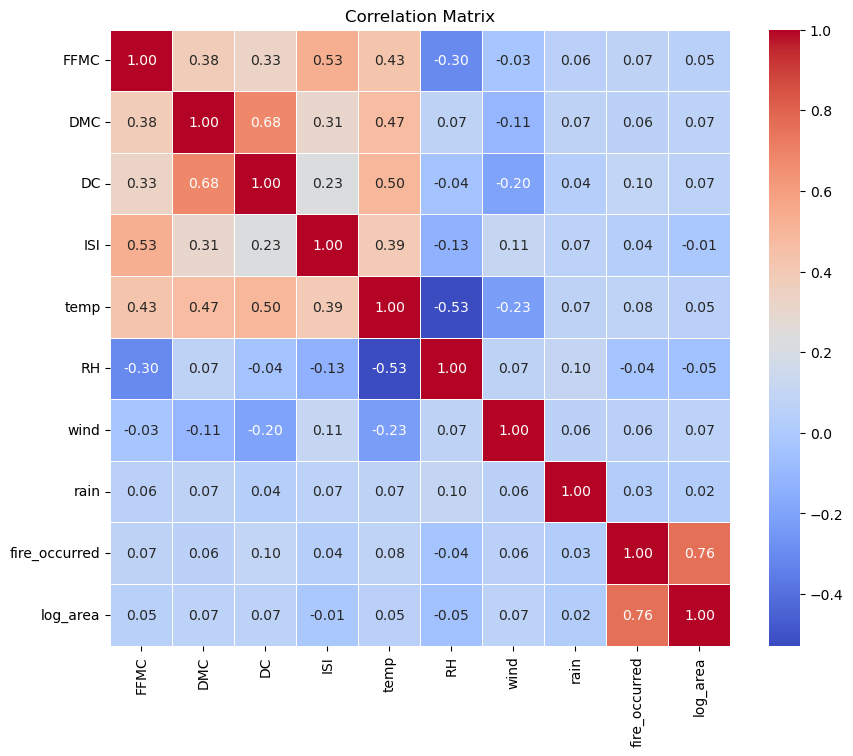

In [39]:
# Explore variable correlations:

#df_forest_fires_cont_vars = df_forest_fires.drop(columns = ['X', 'Y', 'month', 'day', 'area'])
#cont_vars_corr_matrix = df_forest_fires_cont_vars.corr()
#heatmap = sns.heatmap(cont_vars_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Update matrix to analyze log_area
correlation_matrix = df_forest_fires.drop(columns=['X', 'Y', 'month', 'day', 'area']).corr()
target_correlation = correlation_matrix['log_area'].sort_values(ascending=False)

# Display heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

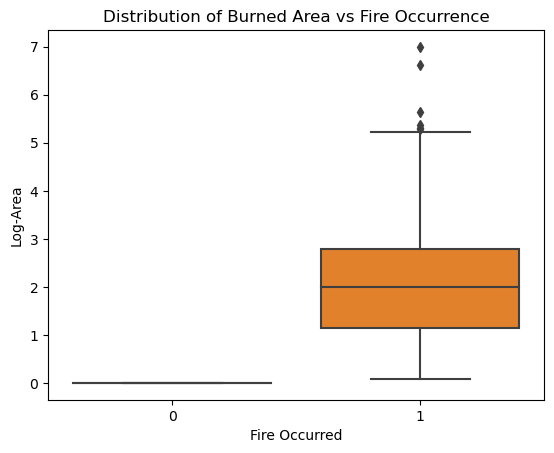

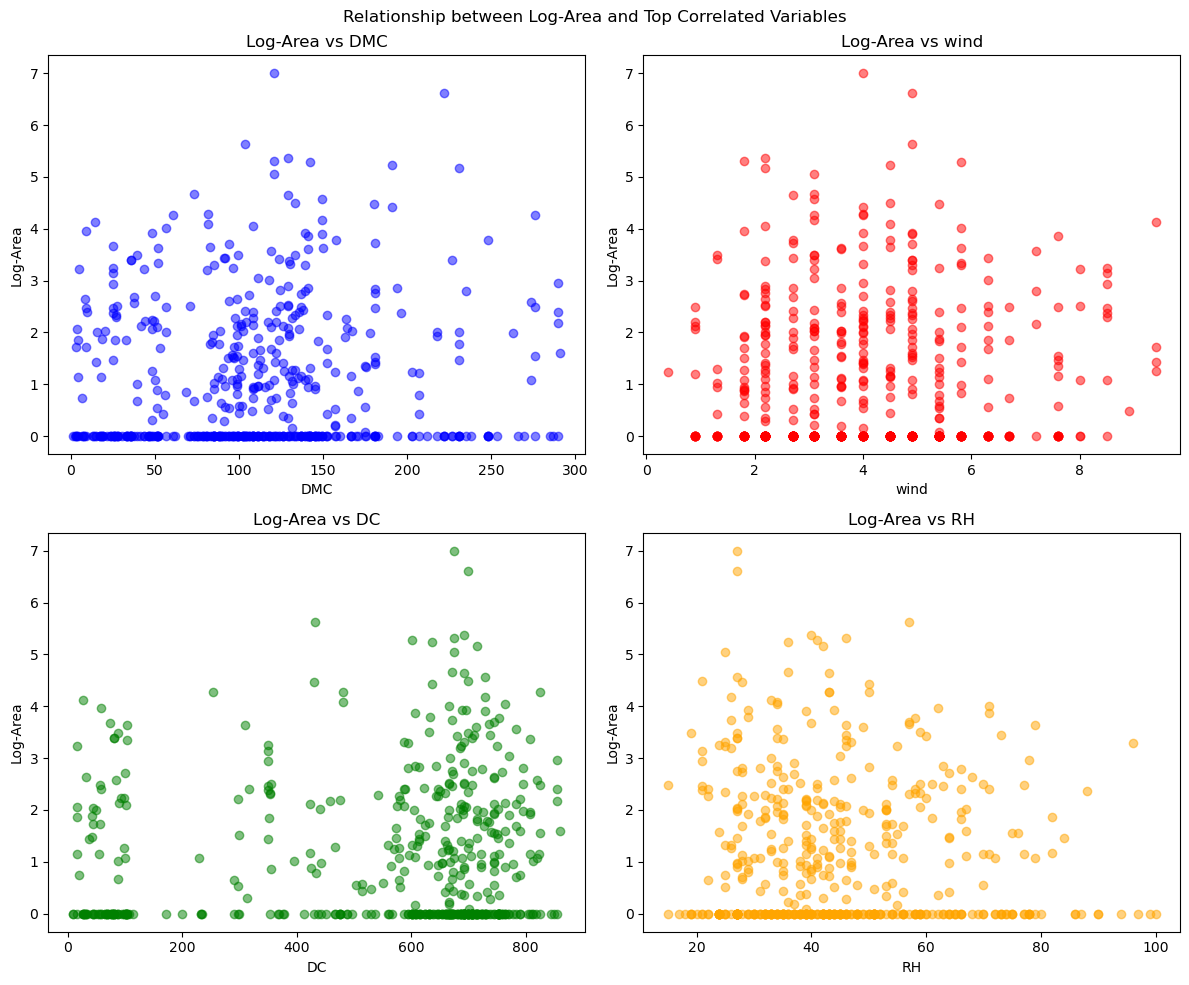

In [40]:
# Scatter plot of fire occurrences to visualize locations of fires 
#df_fire_occurred = df_forest_fires[df_forest_fires['fire_occurred'] == 1]
#plt.scatter(df_fire_occurred['X'], df_fire_occurred['Y'], color = 'red', alpha = 0.5)
#plt.title('Locations Where Fires Occurred')
#plt.xlabel('X Coordinate')
#plt.ylabel('Y Coordinate')
#plt.grid(True)
#plt.show()
# (a plot of the entries when fires occurred with the X Y data to get an idea of vunerable areas)

# Boxplot of 'log_area' against 'fire_occurred' to show the distribution of burn areas where fires did and did not occur
sns.boxplot(x='fire_occurred', y='log_area', data=df_forest_fires)
plt.title('Distribution of Burned Area vs Fire Occurrence')
plt.xlabel('Fire Occurred')
plt.ylabel('Log-Area')
plt.show()

# Select the most correlated variables with 'log_area'
top_corr_vars = correlation_matrix['log_area'].abs().nlargest(7).index.tolist()[2:6]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Relationship between Log-Area and Top Correlated Variables')

axes[0, 0].scatter(df_forest_fires[top_corr_vars[0]], df_forest_fires['log_area'], color='blue', alpha=0.5)
axes[0, 0].set_title(f'Log-Area vs {top_corr_vars[0]}')
axes[0, 0].set_xlabel(top_corr_vars[0])
axes[0, 0].set_ylabel('Log-Area')

axes[0, 1].scatter(df_forest_fires[top_corr_vars[1]], df_forest_fires['log_area'], color='red', alpha=0.5)
axes[0, 1].set_title(f'Log-Area vs {top_corr_vars[1]}')
axes[0, 1].set_xlabel(top_corr_vars[1])
axes[0, 1].set_ylabel('Log-Area')

axes[1, 0].scatter(df_forest_fires[top_corr_vars[2]], df_forest_fires['log_area'], color='green', alpha=0.5)
axes[1, 0].set_title(f'Log-Area vs {top_corr_vars[2]}')
axes[1, 0].set_xlabel(top_corr_vars[2])
axes[1, 0].set_ylabel('Log-Area')

axes[1, 1].scatter(df_forest_fires[top_corr_vars[3]], df_forest_fires['log_area'], color='orange', alpha=0.5)
axes[1, 1].set_title(f'Log-Area vs {top_corr_vars[3]}')
axes[1, 1].set_xlabel(top_corr_vars[3])
axes[1, 1].set_ylabel('Log-Area')

plt.tight_layout()
plt.show()

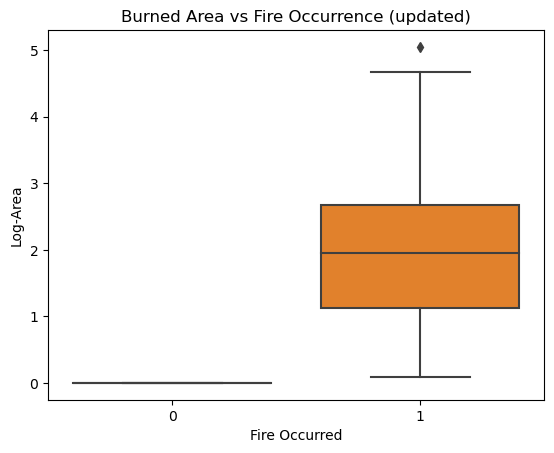

In [41]:
# Remove outliers
Q1 = df_forest_fires['log_area'].quantile(0.25)
Q3 = df_forest_fires['log_area'].quantile(0.75)
IQR = Q3 - Q1

is_outlier = (df_forest_fires['log_area'] < (Q1 - 1.5 * IQR)) | (df_forest_fires['log_area'] > (Q3 + 1.5 * IQR))
df_updated = df_forest_fires[~is_outlier]

# Display boxplot again, with outliers removed
sns.boxplot(x='fire_occurred', y='log_area', data=df_updated)
plt.title('Burned Area vs Fire Occurrence (updated)')
plt.xlabel('Fire Occurred')
plt.ylabel('Log-Area')
plt.show()

In [42]:
# Data preprocessing:

# One-hot encoding for categorical vars ('month', 'day')
categorical_features = ['month', 'day']
one_hot_encoder = OneHotEncoder()
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, categorical_features)],
    remainder='passthrough'
)

# Define feature matrix & target
X = df_updated.drop(['area', 'log_area', 'fire_occurred'], axis=1)
y = np.log1p(df_updated['area'])   # Apply ln(x+1) transformation

# Split data (80/20) into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train_transform = preprocessor.fit_transform(X_train)
X_test_transform = preprocessor.transform(X_test)

# Scale features
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_transform)
X_test_scale = scaler.transform(X_test_transform)

In [43]:
from sklearn.linear_model import SGDRegressor

gradient_descent_model = SGDRegressor(
    loss='squared_error',
    penalty = 'l2',
    max_iter=1000, 
    tol=1e-3, 
    random_state=42,
    alpha = 0.0001,
    epsilon = 0.1,
    verbose = 0,
    learning_rate = 'invscaling',
    eta0 = 0.01,
    power_t = 0.25,
    validation_fraction = 0.1,
    early_stopping = False,
    n_iter_no_change = 5,

)
gradient_descent_model.fit(X_train_scale, y_train)

SGDRegressor(random_state=42)

In [44]:
# Model Evaluation:

# Predict using test dataset
y_pred_scale = gradient_descent_model.predict(X_test_scale)
y_pred = np.expm1(y_pred_scale) # Apply inverse ln(x+1) transformation

# Apply inverse transformation to the true test target values
y_true = np.expm1(y_test)

# Evaluate the MLP model
RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
R2 = r2_score(y_true, y_pred)
MAE = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {RMSE:.2f}")
print(f"R2: {R2:.2f}")
print(f"MAE: {MAE:.2f}")

# Lastly, perform cross-validation
#CV_mse = -cross_val_score(gradient_descent_model, X_train_scale, y_train, cv=5, scoring='neg_mean_squared_error').mean()
#CV_rmse = np.sqrt(CV_mse)
#print(f"Cross-validated RMSE: {CV_rmse:.2f}")

RMSE: 22.14
R2: -0.06
MAE: 7.52


In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'loss': ['squared_error', 'huber'],
    'penalty': ['l2', 'l1'],
    'learning_rate': ['constant', 'invscaling', 'optimal', 'adaptive'],
    'eta0': [0.05, 0.06, 0.3, 0.2, 0.1],
    'alpha': [0.05, 0.06, 0.3, 0.2, 0.1],
    'epsilon': [0.01, 0.02, 0.005]
}

grid = GridSearchCV(estimator=gradient_descent_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train_scale, y_train)

print("Optimal Hyperparameters:", grid.best_params_)
print("Minimum Mean Squared Error:", -1 * grid.best_score_)

c:\Users\ryanm\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\ryanm\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\ryanm\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\ryanm\anaconda3\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\ryanm\anaconda3\Lib\site-packages\sklearn\linea

Optimal Hyperparameters: {'alpha': 0.1, 'epsilon': 0.01, 'eta0': 0.06, 'learning_rate': 'invscaling', 'loss': 'squared_error', 'penalty': 'l1'}
Minimum Mean Squared Error: 1.6454283368844589


In [ ]:
#Use optimized parameters
gradient_descent_model_opt = SGDRegressor(
    loss='squared_error',
    penalty = 'l1',
    max_iter=1000, 
    tol=1e-3, 
    random_state=42,
    alpha = 0.1,
    epsilon = 0.01,
    verbose = 0,
    learning_rate = 'invscaling',
    eta0 = 0.06,
    power_t = 0.25,
    validation_fraction = 0.1,
    early_stopping = False,
    n_iter_no_change = 5,

)
gradient_descent_model_opt.fit(X_train_scale, y_train)

# Model Evaluation:

# Predict using test dataset
y_pred_scale = gradient_descent_model_opt.predict(X_test_scale)
y_pred = np.expm1(y_pred_scale) # Apply inverse ln(x+1) transformation

# Apply inverse transformation to the true test target values
y_true = np.expm1(y_test)

# Evaluate the MLP model
RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
R2 = r2_score(y_true, y_pred)
MAE = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {RMSE:.2f}")
print(f"R2: {R2:.2f}")
print(f"MAE: {MAE:.2f}")

# Lastly, perform cross-validation
#CV_mse = -cross_val_score(gradient_descent_model_opt, X_train_scale, y_train, cv=5, scoring='neg_mean_squared_error').mean()
#CV_rmse = np.sqrt(CV_mse)
#print(f"Cross-validated RMSE: {CV_rmse:.2f}")

RMSE: 22.20
R2: -0.07
MAE: 7.65
